# Benchmark dataset selection process

We sample ~100 time series from all available benchmark dataset, while trying to include time series from any collection.
For some dataset collections, we do not yet have the algorithm's results, so we randomly sample some unprocessed datasets, run TimeEval, and then include them into the overall selection process.

Process:

1. Sample 20 random time series from the unprocessed collections `TSB-UAD-synthetic` and `TSB-UAD-artificial`.
2. Evaluate all algorithms on those 40 datasets using TimeEval.
3. Add the 40 newly processed datasets to our set of candidate datasets.
4. Filter candidate datasets to fit the AutoTSAD constraints:
    - univariate time series
    - at least one anomaly
    - contamination <= 0.1
    - only datasets that could be solved by at least one algorithm with a quality > 0.6
5. Time series sampling per remaining dataset collection


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

root_path = Path("../data/baseline-results/timeeval")
benchmark_data_path = root_path / Path("timeeval-datasets.csv")
gutentag_data_path = root_path / Path("gutentag-datasets.csv")
timeeval_results_path = root_path / Path("timeeval-results.csv")
tsbuad_results_path = root_path / Path("timeeval-results-tsb-uad.csv")
additional_results_path = root_path / Path("timeeval-results-iops-norma.csv")

results_path = root_path.parent / "results-oracle-baselines.csv"

metric_name = "RANGE_PR_AUC"
SEED = 42
contamination_threshold = 0.1
quality_threshold = 0.6


In [2]:
df_datasets = pd.read_csv(benchmark_data_path)
df_gutentag = pd.read_csv(gutentag_data_path)
df_gutentag["collection_name"] = "GutenTAG"
df_gutentag = df_gutentag[df_gutentag["train_type"] == "unsupervised"]
df_gutentag["dataset_name"] = df_gutentag["dataset_name"].str.split(".").str[0]
df_gutentag = df_gutentag.drop_duplicates()
df_datasets = pd.concat([df_datasets, df_gutentag], ignore_index=True)
df_datasets = df_datasets[~df_datasets["collection_name"].isin(["Keogh", "multivariate-anomaly-test-cases"])]
df_datasets = df_datasets.sort_values(["collection_name", "dataset_name"]).reset_index()
df_results = pd.read_csv(timeeval_results_path)
df_results_tsbuad = pd.read_csv(tsbuad_results_path)


In [3]:
# merge results on IOPS and NormA back in
index_cols = ["collection", "dataset", "algorithm", "hyper_params", "hyper_params_id"]
merge_cols = ["train_preprocess_time", "train_main_time", "execute_preprocess_time", "execute_main_time",
               "execute_postprocess_time", "overall_time", "status", "error_message", "error_category", "RANGE_ROC_AUC", "RANGE_PR_AUC", "ROC_AUC",
               "PR_AUC"]

df_tmp = df_results.copy()
df_tmp = df_tmp.set_index(index_cols)

df_new = pd.read_csv(additional_results_path)
df_new = df_new.set_index(index_cols)
df_new["error_category"] = "other"
df_new.loc[df_new["status"] == "Status.OK", "error_category"] = "- OK -"
df_new.loc[df_new["status"] == "Status.TIMEOUT", "error_category"] = "- TIMEOUT -"
df_new.loc[df_new["status"] == "Status.OOM", "error_category"] = "- OOM -"
df_new["overall_time"] = df_new["execute_main_time"].fillna(0) + df_new["train_main_time"].fillna(0)
df_new = df_new[merge_cols]
df_new.sort_index()

new_entries = []
for i, entry in df_new.iterrows():
    if i in df_results.index:
        status = df_tmp.loc[i, "status"]
        if status == "Status.OK":
            continue

        if (status == "Status.ERROR"
            and entry["status"] in ("Status.TIMEOUT", "Status.OOM")) or (entry["status"] == "Status.OK"):
            print(f"Updating {i}: {status} --> {entry['status']}")
            df_tmp.loc[i, merge_cols] = entry[merge_cols]

    else:
        new_entries.append(entry)

df_tmp = pd.concat([df_tmp, pd.DataFrame(new_entries)])
df_results = df_tmp.reset_index()
df_results

,collection,dataset,algorithm,hyper_params,hyper_params_id,algo_training_type,algo_input_dimensionality,dataset_training_type,dataset_input_dimensionality,train_preprocess_time,...,ROC_AUC,PR_AUC,RANGE_PR_AUC,AVERAGE_PRECISION,overall_time,error_category,algo_family,algo_area,algo_display_name,RANGE_ROC_AUC
0,GutenTAG,cbf-combined-diff-1,ARIMA,"{""differencing_degree"": 1, ""distance_metric"": ...",c65230762e5361a11b4faac7164f95bf,UNSUPERVISED,UNIVARIATE,UNSUPERVISED,UNIVARIATE,NaN,...,0.815319,0.465248,0.453215,0.454742,71.414111,- OK -,forecasting,Statistics (Regression & Forecasting),ARIMA,NaN
1,GutenTAG,cbf-combined-diff-3,ARIMA,"{""differencing_degree"": 1, ""distance_metric"": ...",c65230762e5361a11b4faac7164f95bf,UNSUPERVISED,UNIVARIATE,UNSUPERVISED,UNIVARIATE,NaN,...,0.955978,0.127965,0.136431,0.241877,129.666755,- OK -,forecasting,Statistics (Regression & Forecasting),ARIMA,NaN
2,GutenTAG,cbf-diff-count-1,ARIMA,"{""differencing_degree"": 1, ""distance_metric"": ...",c65230762e5361a11b4faac7164f95bf,UNSUPERVISED,UNIVARIATE,UNSUPERVISED,UNIVARIATE,NaN,...,0.439091,0.008516,0.016521,0.014368,72.992341,- OK -,forecasting,Statistics (Regression & Forecasting),ARIMA,NaN
3,GutenTAG,cbf-diff-count-3,ARIMA,"{""differencing_degree"": 1, ""distance_metric"": ...",c65230762e5361a11b4faac7164f95bf,UNSUPERVISED,UNIVARIATE,UNSUPERVISED,UNIVARIATE,NaN,...,0.868527,0.090548,0.053913,0.129214,75.303179,- OK -,forecasting,Statistics (Regression & Forecasting),ARIMA,NaN
4,GutenTAG,cbf-diff-count-4,ARIMA,"{""differencing_degree"": 1, ""distance_metric"": ...",c65230762e5361a11b4faac7164f95bf,UNSUPERVISED,UNIVARIATE,UNSUPERVISED,UNIVARIATE,NaN,...,0.626002,0.054644,0.034841,0.082363,183.925331,- OK -,forecasting,Statistics (Regression & Forecasting),ARIMA,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47113,NormA,SinusRW_Length_116000_AnomalyL_200_AnomalyN_80...,VALMOD,NaN,f74fae266c1a6921831b154bf3f27c7f,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,- OOM -,NaN,NaN,NaN,NaN
47114,NormA,SinusRW_Length_120000_AnomalyL_200_AnomalyN_10...,VALMOD,NaN,f74fae266c1a6921831b154bf3f27c7f,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,- OOM -,NaN,NaN,NaN,NaN
47115,NormA,SinusRW_Length_124000_AnomalyL_400_AnomalyN_60...,VALMOD,NaN,f74fae266c1a6921831b154bf3f27c7f,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,- OOM -,NaN,NaN,NaN,NaN
47116,NormA,SinusRW_Length_148000_AnomalyL_800_AnomalyN_60...,VALMOD,NaN,f74fae266c1a6921831b154bf3f27c7f,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000,- OOM -,NaN,NaN,NaN,NaN


In [4]:
def apply_simple_constraints(df: pd.DataFrame) -> pd.DataFrame:
    df = df[df["input_type"] == "univariate"]
    df = df[df["num_anomalies"] > 0]
    df = df[df["contamination"] <= contamination_threshold]
    return df

### Sample TSB-UAD datasets

In [5]:
# sample 20 random datasets from TSB-UAD-synthetic and TSB-UAD-artificial
df_unprocessed = df_datasets[df_datasets["collection_name"].isin(["TSB-UAD-synthetic", "TSB-UAD-artificial"])]

# already filter datasets based on dataset constraints
df_unprocessed = apply_simple_constraints(df_unprocessed)

df_synthetic = df_unprocessed[df_unprocessed["collection_name"] == "TSB-UAD-synthetic"]
df_artificial = df_unprocessed[df_unprocessed["collection_name"] == "TSB-UAD-artificial"]

rng = np.random.default_rng(SEED)
df_synthetic = df_synthetic.sample(n=20, replace=False, random_state=rng)
df_artificial = df_artificial.sample(n=20, replace=False, random_state=rng)
df_unprocessed = pd.concat([df_synthetic, df_artificial], ignore_index=True)

# create list of dataset ids for TimeEval
dataset_ids = df_unprocessed[["collection_name", "dataset_name"]].apply(lambda x: (x[0], x[1]), axis=1).tolist()
dataset_ids

[('TSB-UAD-synthetic', 'YAHOO_flat_region_0.02-Yahoo_A2synthetic_41_data'),
 ('TSB-UAD-synthetic',
  'YAHOO_change_segment_resampling_0.04-Yahoo_A2synthetic_32_data'),
 ('TSB-UAD-synthetic',
  'KDD21_flip_segment_0.02-210_UCR_Anomaly_Italianpowerdemand_36123_74900_74996'),
 ('TSB-UAD-synthetic', 'YAHOO_flip_segment_0.08-YahooA4Benchmark-TS55_data'),
 ('TSB-UAD-synthetic', 'YAHOO_flat_region_0.08-YahooA4Benchmark-TS33_data'),
 ('TSB-UAD-synthetic', 'YAHOO_flat_region_0.02-Yahoo_A1real_14_data'),
 ('TSB-UAD-synthetic',
  'KDD21_flat_region_0.02-104_UCR_Anomaly_NOISEapneaecg4_6000_16000_16100'),
 ('TSB-UAD-synthetic',
  'KDD21_change_segment_resampling_0.02-033_UCR_Anomaly_DISTORTEDInternalBleeding5_4000_6200_6370'),
 ('TSB-UAD-synthetic',
  'YAHOO_change_segment_resampling_0.02-YahooA3Benchmark-TS84_data'),
 ('TSB-UAD-synthetic',
  'YAHOO_change_segment_add_scale_0.02-YahooA3Benchmark-TS22_data'),
 ('TSB-UAD-synthetic',
  'YAHOO_add_random_walk_trend_0.2-YahooA3Benchmark-TS75_data'),
 ('

### Create and filter candidate dataset list

In [6]:
# find best algo per dataset
agg_columns = [
    "algorithm", "hyper_params", "hyper_params_id", "overall_time", "RANGE_ROC_AUC",
    "RANGE_PR_AUC", "ROC_AUC", "PR_AUC"
]
df = pd.concat([df_results, df_results_tsbuad], axis=0, ignore_index=True)
df = df.sort_values(["collection", "dataset", metric_name], ascending=[True, True, False])
aggs = dict((c, "first") for c in agg_columns if c in df.columns and c != metric_name)
df = df.groupby(["collection", "dataset"]).agg({
    metric_name: "max",
    **aggs
})
df.groupby("algorithm")[metric_name].count().sort_values(ascending=False)

algorithm
GrammarViz                         68
FFT                                68
k-Means                            62
DBStream                           58
ARIMA                              49
Triple ES (Holt-Winter's)          48
DWT-MLEAD                          45
STAMP                              41
MedianMethod                       40
Subsequence LOF                    39
PCI                                35
DSPOT                              34
Spectral Residual (SR)             32
Torsk                              30
VALMOD                             25
Left STAMPi                        22
NormA                              22
PCC                                21
Hybrid KNN                         19
HOT SAX                            19
SAND                               16
HBOS                               15
CBLOF                              15
COPOD                              15
Series2Graph                       14
SSA                                14
KN

In [7]:
# create list of datasets and apply base filters
df_filtered_datasets = apply_simple_constraints(df_datasets)
df_filtered_datasets = df_filtered_datasets[df_filtered_datasets["collection_name"] != "TSB-UAD-synthetic"]
df_filtered_datasets = df_filtered_datasets[df_filtered_datasets["collection_name"] != "TSB-UAD-artificial"]
df_filtered_datasets = pd.concat([df_filtered_datasets, df_unprocessed], ignore_index=True)
df_filtered_datasets.shape[0]

952

Number of datasets: 952
Number of datasets without best algo: 9


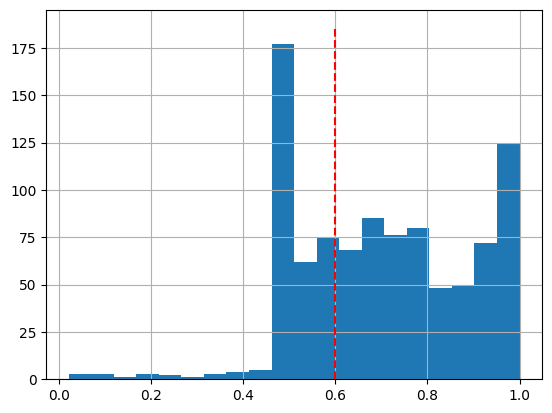

Remaining datasets after algorithm quality filtering: 618


collection_name
WebscopeS5            229
KDD-TSAD              135
GutenTAG              133
NASA-SMAP              31
NAB                    26
TSB-UAD-synthetic      20
NASA-MSL               15
IOPS                   14
NormA                   7
MGAB                    4
TSB-UAD-artificial      4
Name: dataset_name, dtype: int64

In [8]:
df_tmp = pd.merge(df_filtered_datasets, df, left_on=["collection_name", "dataset_name"], right_on=["collection", "dataset"], how="left")
# df_tmp = df_tmp.rename(columns={
#     "algorithm": "best_algo",
#     "hyper_params": "best_algo_hyper_params",
#     "hyper_params_id": "best_algo_hyper_params_id",
#     metric_name: "best_algo_metric"
# })
print(f"Number of datasets: {df_tmp.shape[0]}")
print(f"Number of datasets without best algo: {df_tmp[metric_name].isna().sum()}")
df_tmp[metric_name].hist(bins=20)
ymin, ymax = plt.gca().get_ylim()
plt.vlines(quality_threshold, ymin=ymin, ymax=ymax, colors="red", linestyles="dashed")
plt.show()

# filter datasets based on best algo metric (exclude not-evaluated datasets)
# df_tmp = df_tmp[(df_tmp[metric_name].isna()) | (df_tmp[metric_name] > quality_threshold)]
df_tmp = df_tmp[df_tmp[metric_name] > quality_threshold]

print(f"Remaining datasets after algorithm quality filtering: {df_tmp.shape[0]}")
df_candidates = df_tmp
df_tmp.groupby("collection_name")["dataset_name"].count().sort_values(ascending=False)


### Sample datasets per collection


In [9]:
# sample 10 datasets per collection
df_selected = df_candidates.groupby("collection_name").apply(lambda x: x.sample(n=min(10, x.shape[0]), replace=False, random_state=SEED)).reset_index(drop=True)
df_selected.groupby("collection_name")["dataset_name"].count().sort_values(ascending=False)

collection_name
GutenTAG              10
IOPS                  10
KDD-TSAD              10
NAB                   10
NASA-MSL              10
NASA-SMAP             10
TSB-UAD-synthetic     10
WebscopeS5            10
NormA                  7
MGAB                   4
TSB-UAD-artificial     4
Name: dataset_name, dtype: int64

### Sample additional datasets for revision

In [10]:
# sample 10 additional datasets per collection
df_remaining = df_candidates[~df_candidates["index"].isin(df_selected["index"].values)]
df_selected2 = df_remaining.groupby("collection_name").apply(lambda x: x.sample(n=min(10, x.shape[0]), replace=False, random_state=SEED)).reset_index(drop=True)
df_selected2.groupby("collection_name")["dataset_name"].count().sort_values(ascending=False)

collection_name
GutenTAG             10
KDD-TSAD             10
NAB                  10
NASA-SMAP            10
TSB-UAD-synthetic    10
WebscopeS5           10
NASA-MSL              5
IOPS                  4
Name: dataset_name, dtype: int64

In [11]:
df_selected = pd.concat([df_selected, df_selected2]).sort_values(["collection_name", "dataset_name"])

In [12]:
dataset_names = df_selected[["collection_name", "dataset_name"]].apply(lambda x: (x[0], x[1]), axis=1).tolist()
dataset_names

[('GutenTAG', 'cbf-position-middle'),
 ('GutenTAG', 'ecg-diff-count-1'),
 ('GutenTAG', 'ecg-diff-count-8'),
 ('GutenTAG', 'ecg-same-count-1'),
 ('GutenTAG', 'ecg-same-count-2'),
 ('GutenTAG', 'ecg-type-mean'),
 ('GutenTAG', 'ecg-type-pattern-shift'),
 ('GutenTAG', 'ecg-type-trend'),
 ('GutenTAG', 'poly-diff-count-2'),
 ('GutenTAG', 'poly-diff-count-5'),
 ('GutenTAG', 'poly-length-10'),
 ('GutenTAG', 'poly-length-500'),
 ('GutenTAG', 'poly-trend-linear'),
 ('GutenTAG', 'rw-combined-diff-1'),
 ('GutenTAG', 'rw-combined-diff-2'),
 ('GutenTAG', 'rw-length-100'),
 ('GutenTAG', 'sinus-diff-count-2'),
 ('GutenTAG', 'sinus-length-50'),
 ('GutenTAG', 'sinus-position-middle'),
 ('GutenTAG', 'sinus-type-mean'),
 ('IOPS', '05f10d3a-239c-3bef-9bdc-a2feeb0037aa'),
 ('IOPS', '1c6d7a26-1f1a-3321-bb4d-7a9d969ec8f0'),
 ('IOPS', '431a8542-c468-3988-a508-3afd06a218da'),
 ('IOPS', '4d2af31a-9916-3d9f-8a8e-8a268a48c095'),
 ('IOPS', '54350a12-7a9d-3ca8-b81f-f886b9d156fd'),
 ('IOPS', '57051487-3a40-3828-9084-

In [13]:
# collection_name,dataset_name,algorithm,hyper_params,hyper_params_id,range_pr_auc,overall_runtime,range_roc_auc
df_oracle_results = df_selected[[
    "collection_name", "dataset_name", "algorithm", "hyper_params",
    "hyper_params_id", "overall_time", "RANGE_PR_AUC", "RANGE_ROC_AUC",
    "ROC_AUC", "PR_AUC"
]]
df_oracle_results = df_oracle_results.rename(columns={
    "overall_time": "overall_runtime",
    "RANGE_PR_AUC": "range_pr_auc",
    "RANGE_ROC_AUC": "range_roc_auc",
    "ROC_AUC": "roc_auc",
    "PR_AUC": "pr_auc",
})
df_oracle_results = df_oracle_results.reset_index(drop=True)
df_oracle_results.to_csv(results_path, index=False)
df_oracle_results

,collection_name,dataset_name,algorithm,hyper_params,hyper_params_id,overall_runtime,range_pr_auc,range_roc_auc,roc_auc,pr_auc
0,GutenTAG,cbf-position-middle,Hybrid Isolation Forest (HIF),"{""n_trees"": 500, ""random_state"": 42}",afa2d8319abe6f297ccc948af3c450b6,446.183264,0.885175,NaN,0.998480,0.874073
1,GutenTAG,ecg-diff-count-1,DWT-MLEAD,"{""quantile_epsilon"": 0.1, ""random_state"": 42, ...",40813f7d4823570c94e220a39d8b69e0,9.124367,0.823690,NaN,0.999168,0.862320
2,GutenTAG,ecg-diff-count-8,GrammarViz,"{""alphabet_size"": 6, ""anomaly_window_size"": 10...",68167f8cebb34ba892274e7ce6017715,27.601419,0.790185,NaN,0.988398,0.821192
3,GutenTAG,ecg-same-count-1,DWT-MLEAD,"{""quantile_epsilon"": 0.1, ""random_state"": 42, ...",40813f7d4823570c94e220a39d8b69e0,6.482181,0.961786,NaN,0.999677,0.968557
4,GutenTAG,ecg-same-count-2,LSTM-AD,"{""batch_size"": 64, ""early_stopping_delta"": 0.0...",52b52795e79a01eae71c1fc93e1819f7,7647.343061,0.977512,NaN,0.999974,0.998768
...,...,...,...,...,...,...,...,...,...,...
159,WebscopeS5,A4Benchmark-34,Spectral Residual (SR),"{""mag_window_size"": 40, ""random_state"": 42, ""s...",f61ee363987c8d877a5f9ee8f6d78334,3.740622,0.791918,NaN,0.997981,0.902153
160,WebscopeS5,A4Benchmark-63,VALMOD,"{""exclusion_zone"": 0.5, ""heap_size"": 50, ""max_...",f74fae266c1a6921831b154bf3f27c7f,3.429952,0.656848,NaN,0.987533,0.292705
161,WebscopeS5,A4Benchmark-67,PCI,"{""random_state"": 42, ""thresholding_p"": 0.05, ""...",065ce526b23dc55e9fceed01566107ce,4.779998,0.737287,NaN,0.870972,0.753499
162,WebscopeS5,A4Benchmark-88,PCI,"{""random_state"": 42, ""thresholding_p"": 0.05, ""...",065ce526b23dc55e9fceed01566107ce,4.246872,0.636220,NaN,0.931211,0.667513


## Build CSV file with paths to dataset candidates

In [14]:
from timeeval import DatasetManager

# adapt paths to your local setup!
paths = [
    Path("../../data/benchmark-data/data-processed").resolve(),
    Path("../../data/univariate-anomaly-test-cases").resolve(),
]

In [15]:
dfs = []
for path in paths:
    dmgr = DatasetManager(path, create_if_missing=False)
    df_tmp = dmgr.df().reset_index()[["collection_name", "dataset_name", "test_path"]].copy()
    df_tmp["test_path"] = df_tmp["test_path"].apply(lambda x: path / x)
    dfs.append(df_tmp)

In [16]:
df_dataset_paths = pd.concat(dfs, ignore_index=True)
mask = df_dataset_paths["collection_name"] == "univariate-anomaly-test-cases"
df_dataset_paths.loc[mask, "collection_name"] = "GutenTAG"
df_dataset_paths.loc[mask, "dataset_name"] = df_dataset_paths.loc[mask, "dataset_name"].str.split(".").str[0]
df_dataset_paths = df_dataset_paths.drop_duplicates()
df_dataset_paths = pd.merge(df_selected[["collection_name", "dataset_name"]], df_dataset_paths, on=["collection_name", "dataset_name"], how="left")
df_dataset_paths = df_dataset_paths.rename(columns={
    "collection_name": "collection",
    "dataset_name": "dataset",
    "test_path": "dataset_path"
})
df_dataset_paths["paper"] = True
df_dataset_paths.to_csv("autotsad-dataset-paths-sebastian-laptop.csv", index=False)
df_dataset_paths

,collection,dataset,dataset_path,paper
0,GutenTAG,cbf-position-middle,/home/sebastian/Documents/projects/akita/data/...,True
1,GutenTAG,ecg-diff-count-1,/home/sebastian/Documents/projects/akita/data/...,True
2,GutenTAG,ecg-diff-count-8,/home/sebastian/Documents/projects/akita/data/...,True
3,GutenTAG,ecg-same-count-1,/home/sebastian/Documents/projects/akita/data/...,True
4,GutenTAG,ecg-same-count-2,/home/sebastian/Documents/projects/akita/data/...,True
...,...,...,...,...
159,WebscopeS5,A4Benchmark-34,/home/sebastian/Documents/projects/akita/data/...,True
160,WebscopeS5,A4Benchmark-63,/home/sebastian/Documents/projects/akita/data/...,True
161,WebscopeS5,A4Benchmark-67,/home/sebastian/Documents/projects/akita/data/...,True
162,WebscopeS5,A4Benchmark-88,/home/sebastian/Documents/projects/akita/data/...,True
